**Executed:** Tue Feb 21 16:16:26 2017

**Duration:** 14 seconds.

In [1]:
# default values of file paths, assuming quantum_fog is working dir
in_bif = 'examples_cbnets/earthquake.bif'
in_dot = 'examples_cbnets/earthquake.dot'
in_csv = 'learning/training_data_c/earthquake.csv'

In [2]:
# Cell inserted during automated execution.
in_bif = 'examples_cbnets/asia_.bif'
in_dot = 'examples_cbnets/asia_.dot'
in_csv = 'learning/training_data_c/tempo.csv'

In [3]:
learned_dot = 'examples_cbnets/tempo.dot'  # for storing learned network

**Structure Learning Template**

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#True-Network-Structure" data-toc-modified-id="True-Network-Structure-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>True Network Structure</a></div><div class="lev1 toc-item"><a href="#Learned-Network-Structures" data-toc-modified-id="Learned-Network-Structures-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Learned Network Structures</a></div><div class="lev2 toc-item"><a href="#MB-based-learning" data-toc-modified-id="MB-based-learning-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>MB based learning</a></div><div class="lev3 toc-item"><a href="#Grow-Shink" data-toc-modified-id="Grow-Shink-211"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Grow Shink</a></div><div class="lev3 toc-item"><a href="#IAMB" data-toc-modified-id="IAMB-212"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>IAMB</a></div><div class="lev2 toc-item"><a href="#Score-based-learning" data-toc-modified-id="Score-based-learning-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Score based learning</a></div><div class="lev3 toc-item"><a href="#Hiil-Climbing-with-BIC-score" data-toc-modified-id="Hiil-Climbing-with-BIC-score-221"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Hiil Climbing with BIC score</a></div><div class="lev2 toc-item"><a href="#Summary-of-Running-Times" data-toc-modified-id="Summary-of-Running-Times-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Summary of Running Times</a></div>

In [4]:
import pandas as pd
import numpy as np
from graphviz import Source

import warnings
warnings.filterwarnings("ignore", module="rpy2")

import rpy2
%load_ext rpy2.ipython
%R library("bnlearn");
%R library("Rgraphviz");

In [5]:
# make this the absolute path of quantum-fog folder
qfog_path = '/home/jupyter/Notebooks/quantum-fog'

In [6]:
import os
import sys
if qfog_path != os.getcwd():
    os.chdir('../../')
    sys.path.insert(0,os.getcwd())
from learning.NaiveBayesLner import *
from learning.MB_GrowShrinkLner import *
from learning.MB_IAMB_Lner import *
from learning.HillClimbingLner import *

Read in_csv, create Pandas Dataframe with it, push dataframe into R

In [7]:
states_df = pd.read_csv(in_csv)
states_df.head()

,Smoke,Bronchitis,LungCancer,Visited_AsianTBHRA,Tuberculosis,Either,Dyspnea,XRay
0,0,0,1,1,1,1,0,1
1,1,0,1,1,1,1,0,1
2,1,0,1,1,1,1,0,1
3,0,0,1,1,1,1,0,1
4,0,0,1,1,1,1,0,1


In [8]:
states_df.tail()

,Smoke,Bronchitis,LungCancer,Visited_AsianTBHRA,Tuberculosis,Either,Dyspnea,XRay
1995,0,0,1,1,1,1,0,1
1996,0,1,1,1,1,1,1,1
1997,0,0,1,1,1,1,0,1
1998,1,1,1,1,1,1,1,1
1999,1,0,1,1,1,1,0,1


In [9]:
%Rpush states_df
%R str(states_df)

'data.frame':	2000 obs. of  8 variables:
 $ Smoke             : int  0 1 1 0 0 0 0 0 1 0 ...
 $ Bronchitis        : int  0 0 0 0 0 0 0 0 1 0 ...
 $ LungCancer        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Visited_AsianTBHRA: int  1 1 1 1 1 1 1 1 1 1 ...
 $ Tuberculosis      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Either            : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Dyspnea           : int  0 0 0 0 0 0 0 0 1 0 ...
 $ XRay              : int  1 1 1 1 1 1 1 1 1 1 ...


For bnlearn, data.frame columns cannot be int type, must be changed to factor.
data.frame is a list so can use lapply

In [10]:
%R states_df[] <- lapply(states_df, factor)
%R str(states_df)

'data.frame':	2000 obs. of  8 variables:
 $ Smoke             : Factor w/ 2 levels "0","1": 1 2 2 1 1 1 1 1 2 1 ...
 $ Bronchitis        : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 2 1 ...
 $ LungCancer        : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Visited_AsianTBHRA: Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Tuberculosis      : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Either            : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Dyspnea           : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 2 1 ...
 $ XRay              : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...


# True Network Structure

In [11]:
from IPython.display import Image, display, DisplayObject
def show_dot(dotfile):
    Source(open(dotfile).read(),format ='png').render(view=False);
    display(Image(filename='Source.gv.png'))

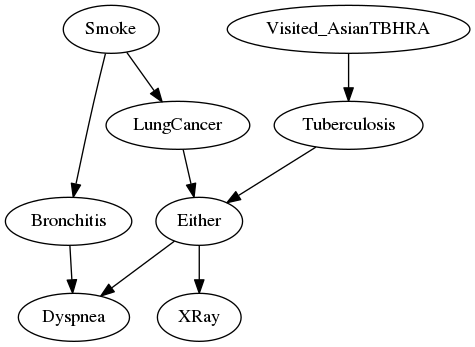

In [12]:
show_dot(in_dot)

# Learned Network Structures
## MB based learning
### Grow Shink
#### Qfog

In [13]:
%%capture qfog_gs_time
alpha = 8/len(states_df.index)
%time lnr = MB_GrowShrinkLner(states_df, alpha, verbose=False)

In [14]:
print(qfog_gs_time)

CPU times: user 1.5 s, sys: 12.1 ms, total: 1.51 s
Wall time: 1.51 s



In [15]:
lnr.bnet.write_dot(learned_dot) # write BNet to .dot file

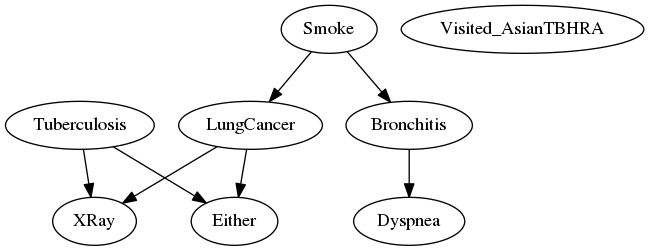

In [16]:
show_dot(learned_dot)

#### bnlearn

In [17]:
%%capture bnlearn_gs_time
%time %R bn <- gs(states_df);

In [18]:
print(bnlearn_gs_time)

CPU times: user 35.8 ms, sys: 0 ns, total: 35.8 ms
Wall time: 36 ms



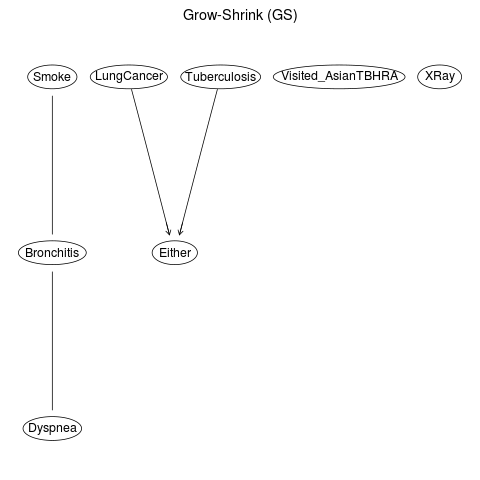

In [19]:
%R par(mfrow = c(1,1))
%R graphviz.plot(bn, shape = "ellipse", main = "Grow-Shrink (GS)");

### IAMB
#### QFog

In [20]:
%%capture qfog_iamb_time
alpha = 8/len(states_df.index)
%time lnr = MB_IAMB_Lner(states_df, alpha, verbose=False)

In [21]:
print(qfog_iamb_time)

CPU times: user 1.3 s, sys: 48 us, total: 1.3 s
Wall time: 1.3 s



In [22]:
lnr.bnet.write_dot(learned_dot) # write BNet to .dot file

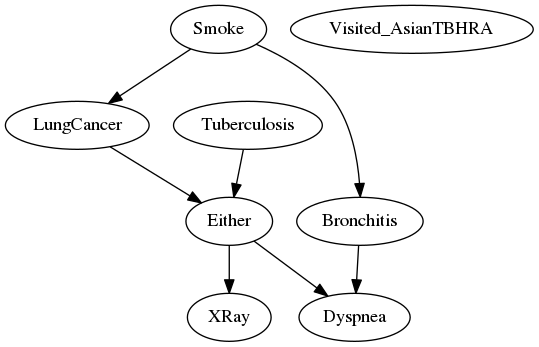

In [23]:
show_dot(learned_dot)

Results are sensitive to "alpha"

#### bnlearn

In [24]:
%%capture  bnlearn_iamb_time
%time %R bn <- iamb(states_df);

In [25]:
print(bnlearn_iamb_time)

CPU times: user 21.3 ms, sys: 37 us, total: 21.3 ms
Wall time: 21.5 ms



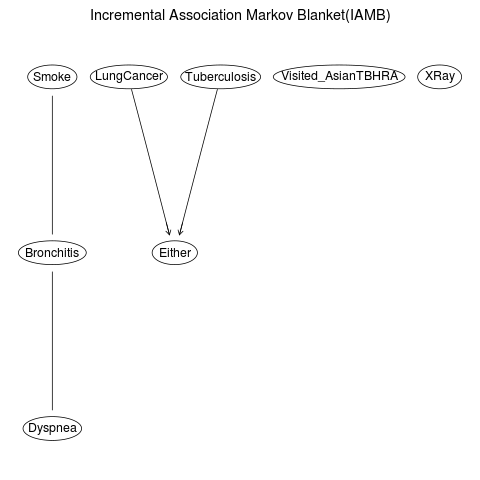

In [26]:
%R par(mfrow = c(1,1))
%R graphviz.plot(bn, shape = "ellipse", main = "Incremental Association Markov Blanket(IAMB)");

## Score based learning
### Hiil Climbing with BIC score
#### QFog

In [27]:
%%capture qfog_hc_bic_time
score_type = 'BIC'
max_num_mtries = 30
ess = 1.0 
%time lnr = HillClimbingLner(states_df, score_type, max_num_mtries, ess)

In [28]:
print(qfog_hc_bic_time)

CPU times: user 6.75 s, sys: 102 us, total: 6.75 s
Wall time: 6.76 s



In [29]:
lnr.bnet.write_dot(learned_dot) # write BNet to .dot file

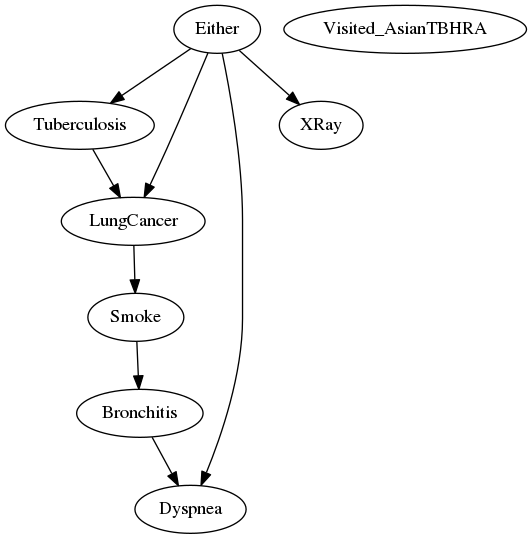

In [30]:
show_dot(learned_dot)

#### bnlearn

In bnlearn, the default score is **BIC** (Bayesian Information Criterion) for both discrete and continuous data sets

In [31]:
%%capture bnlearn_hc_bic_time
%time %R bn <- hc(states_df);

In [32]:
print(bnlearn_hc_bic_time)

CPU times: user 23.6 ms, sys: 0 ns, total: 23.6 ms
Wall time: 23.9 ms



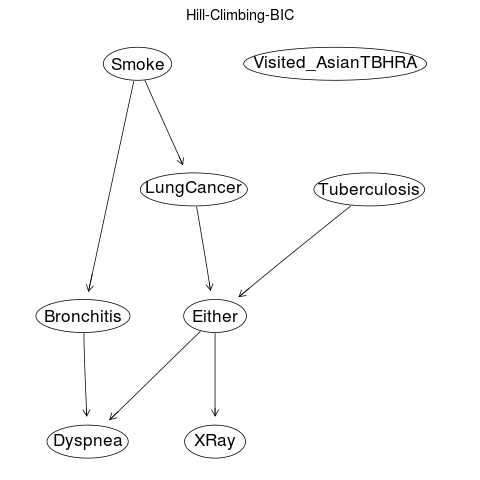

In [33]:
%R par(mfrow = c(1,1))
%R graphviz.plot(bn, shape = "ellipse", main = "Hill-Climbing-BIC");

## Summary of Running Times

In [34]:
%%bash
rm -f examples_cbnets/tempo.dot Source.gv Source.gv.png

In [35]:
print("-------------Grow-Shrink:")
print("QFog:", qfog_gs_time)
print("bnlearn:", bnlearn_gs_time)

print("-------------IAMB")
print("QFog:", qfog_iamb_time)
print("bnlearn:", bnlearn_iamb_time)

print("-------------Hill Climbing with BIC score:")
print("QFog:", qfog_hc_bic_time)
print("bnlearn:", bnlearn_hc_bic_time)

-------------Grow-Shrink:
QFog: CPU times: user 1.5 s, sys: 12.1 ms, total: 1.51 s
Wall time: 1.51 s

bnlearn: CPU times: user 35.8 ms, sys: 0 ns, total: 35.8 ms
Wall time: 36 ms

-------------IAMB
QFog: CPU times: user 1.3 s, sys: 48 us, total: 1.3 s
Wall time: 1.3 s

bnlearn: CPU times: user 21.3 ms, sys: 37 us, total: 21.3 ms
Wall time: 21.5 ms

-------------Hill Climbing with BIC score:
QFog: CPU times: user 6.75 s, sys: 102 us, total: 6.75 s
Wall time: 6.76 s

bnlearn: CPU times: user 23.6 ms, sys: 0 ns, total: 23.6 ms
Wall time: 23.9 ms

